In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

## Funções para extrair acertos
A maioria das análises TRI vão precisar de uma "dicomitização" das respostas. A estrutura de dados que vamos precisar é uma matriz com colunas itens e linhas pessoas com valores 0 e 1 para erros e acertos respectivamente.

Vamos tentar criar umas funções que crie este estrutura de dados.


Temos algumas informações sobre a estrutura dos microdados:
* não vamos usar as primeiras 10 itens da prova LC (Linguágens e Códigos). Desde 2011 (?) estas posições são usadas para as questões de língua estrangeira (espanhol ou inglês). Acredito que somente 40 questões de LC são usados para criar a escala IRT desta prova.
* O INEP divulga, desde o final de 2022, os parámetros IRT (discriminação, dificuldade e c). Além disso, dizem quais itens foram eliminados ("pelo IRT"), porque aparentemente atrapalharam a convergência da estimação do modelo IRT 3PL que estão usando. Vamos ter que tirar estes itens também.  

In [165]:
df = pd.read_csv('data/enem19-1perc.csv',dtype={'CO_PROVA_LC':int,'CO_PROVA_CN':int,'CO_PROVA_CH':int,'CO_PROVA_MT':int})
item_info = pd.read_csv('data/ITENS_PROVA_2019-utf8.csv')
print(list(item_info.columns),'\n')
print(list(df.columns))

['CO_POSICAO', 'SG_AREA', 'CO_ITEM', 'TX_GABARITO', 'CO_HABILIDADE', 'IN_ITEM_ABAN', 'TX_MOTIVO_ABAN', 'NU_PARAM_A', 'NU_PARAM_B', 'NU_PARAM_C', 'TX_COR', 'CO_PROVA', 'TP_LINGUA', 'IN_ITEM_ADAPTADO'] 

['NU_INSCRICAO', 'NU_ANO', 'CO_MUNICIPIO_RESIDENCIA', 'NO_MUNICIPIO_RESIDENCIA', 'CO_UF_RESIDENCIA', 'SG_UF_RESIDENCIA', 'NU_IDADE', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'CO_MUNICIPIO_NASCIMENTO', 'NO_MUNICIPIO_NASCIMENTO', 'CO_UF_NASCIMENTO', 'SG_UF_NASCIMENTO', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO', 'IN_TREINEIRO', 'CO_ESCOLA', 'CO_MUNICIPIO_ESC', 'NO_MUNICIPIO_ESC', 'CO_UF_ESC', 'SG_UF_ESC', 'TP_DEPENDENCIA_ADM_ESC', 'TP_LOCALIZACAO_ESC', 'TP_SIT_FUNC_ESC', 'IN_BAIXA_VISAO', 'IN_CEGUEIRA', 'IN_SURDEZ', 'IN_DEFICIENCIA_AUDITIVA', 'IN_SURDO_CEGUEIRA', 'IN_DEFICIENCIA_FISICA', 'IN_DEFICIENCIA_MENTAL', 'IN_DEFICIT_ATENCAO', 'IN_DISLEXIA', 'IN_DISCALCULIA', 'IN_AUTISMO', 'IN_VISAO_MONOCULAR', 'IN_OUTRA_DEF', 'IN_GESTANTE', 'IN_LACTANTE',

In [160]:
item_info.query("IN_ITEM_ABAN == 1")

,CO_POSICAO,SG_AREA,CO_ITEM,TX_GABARITO,CO_HABILIDADE,IN_ITEM_ABAN,TX_MOTIVO_ABAN,NU_PARAM_A,NU_PARAM_B,NU_PARAM_C,TX_COR,CO_PROVA,TP_LINGUA,IN_ITEM_ADAPTADO
219,15,LC,118260,E,15,1,Não permitiu a convergência do algoritmo de es...,NaN,NaN,NaN,Branca,514,NaN,0
371,29,LC,118260,E,15,1,Não permitiu a convergência do algoritmo de es...,NaN,NaN,NaN,Amarela,512,NaN,0
372,29,LC,118260,E,15,1,Não permitiu a convergência do algoritmo de es...,NaN,NaN,NaN,Laranja,521,NaN,0
373,29,LC,118260,E,15,1,Não permitiu a convergência do algoritmo de es...,NaN,NaN,NaN,Verde,525,NaN,1
416,33,LC,118260,E,15,1,Não permitiu a convergência do algoritmo de es...,NaN,NaN,NaN,Azul,511,NaN,0
450,36,LC,118260,E,15,1,Não permitiu a convergência do algoritmo de es...,NaN,NaN,NaN,Rosa,513,NaN,0
582,48,CH,118067,C,29,1,Não permitiu a convergência do algoritmo de es...,NaN,NaN,NaN,Azul,507,NaN,0
770,66,CH,76955,B,27,1,Não permitiu a convergência do algoritmo de es...,NaN,NaN,NaN,Branca,509,NaN,0
813,69,CH,118067,C,29,1,Não permitiu a convergência do algoritmo de es...,NaN,NaN,NaN,Branca,509,NaN,0
841,72,CH,76955,B,27,1,Não permitiu a convergência do algoritmo de es...,NaN,NaN,NaN,Rosa,510,NaN,0


In [298]:
item_info.query("CO_ITEM == 118067")

,CO_POSICAO,SG_AREA,CO_ITEM,TX_GABARITO,CO_HABILIDADE,IN_ITEM_ABAN,TX_MOTIVO_ABAN,NU_PARAM_A,NU_PARAM_B,NU_PARAM_C,TX_COR,CO_PROVA,TP_LINGUA,IN_ITEM_ADAPTADO
582,48,CH,118067,C,29,1,Não permitiu a convergência do algoritmo de es...,NaN,NaN,NaN,Azul,507,NaN,0
813,69,CH,118067,C,29,1,Não permitiu a convergência do algoritmo de es...,NaN,NaN,NaN,Branca,509,NaN,0
879,75,CH,118067,C,29,1,Não permitiu a convergência do algoritmo de es...,NaN,NaN,NaN,Rosa,510,NaN,0
943,81,CH,118067,C,29,1,Não permitiu a convergência do algoritmo de es...,NaN,NaN,NaN,Amarela,508,NaN,0
944,81,CH,118067,C,29,1,Não permitiu a convergência do algoritmo de es...,NaN,NaN,NaN,Laranja,520,NaN,0
945,81,CH,118067,C,29,1,Não permitiu a convergência do algoritmo de es...,NaN,NaN,NaN,Verde,524,NaN,1


In [154]:
df["TX_RESPOSTAS_LC"].sample(10)

16719    BDCBE99999CEBDBDDCBEDAEEEEAEBBDCDCCCEDDAADEBED...
490      99999DEBEDDCCBBEEACCCBDDCDCDCCCDDBDDEAEADCEEEA...
15218    99999EEAACBBADDEDCDDECECACDEDECBDBEAACDDEEDDCC...
7969     ADBBE99999ABCCBCDACECDDDCAADDCADECDCDBDEBAECBE...
24767    BBABD99999CCBABEEBADBAAECACEECDCCBCACCEACDAABE...
11384    99999EBBEADDCBEDBAEBDDDDCDBEAEBADEEEEABACAECCE...
27679    CBBAD99999ABCDCCCDBACBBDEADCACAEDAABACEADCACAA...
30204    BAEDA99999CCCBECDEACBAEBCEDCBBEAEBACCDCEECBCEA...
30302    BBEDA99999CCABEECBBCBACCCEDABEEDEDAAADDEECCECA...
12816    EBBAB99999CDCECDBDBBDABDDDEBDACAABBBACCACDEBCC...
Name: TX_RESPOSTAS_LC, dtype: object

In [114]:
df["TX_GABARITO_CN"].sample(10)

20483    DADCCEBBCCACBEEBEEBACBCDDDDADBCBBCEAEADEADAAE
29954    BEEAAEBEEBADEADDADAEABCEDDDBCBCBCCACBCDADCCEB
26827    BEEAAEBEEBADEADDADAEABCEDDDBCBCBCCACBCDADCCEB
19696    DADCCEBBCCACBEEBEEBACBCDDDDADBCBBCEAEADEADAAE
11882    DADCCEBBCCACBEEBEEBACBCDDDDADBCBBCEAEADEADAAE
11255    BEEAAEBEEBADEADDADAEABCEDDDBCBCBCCACBCDADCCEB
13298    AAECACDEADCBCDDDBCBDADAEABCEBABEEBCBEECEBDADC
9398     DEADBAAAEBEECEBCBCBCBDADAEABCEDDDDADCBEECACBC
16330    DADCCEBBCCACBEEBEEBACBCDDDDADBCBBCEAEADEADAAE
27697    AAECACDEADCBCDDDBCBDADAEABCEBABEEBCBEECEBDADC
Name: TX_GABARITO_CN, dtype: object

In [200]:
gab = df.loc[16562,"TX_GABARITO_LC"]
resp = df.loc[16562,"TX_RESPOSTAS_LC"]
print(resp)
print(gab)

99999BEECACCDEEECCEDACECDAAACCECCBBAADEDECBDEADECA
BBEDABDACACBABAECBBCCADCEBDBBCDDEEAAADDBECDECAAECD


In [116]:
[r == g for r,g in zip(resp,gab)]

[True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 True,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 True,
 False,
 False]

In [221]:
def to_acertos(s):
    'resp e gab são strings, retorna uma lista'
    resp = s[0]
    gab = s[1]
    return [r == g for r,g in zip(resp,gab)]

def acertos_df(df,exame,as_int=True):
    'Retorna dataframe com acertos. Colunas 1-45 = itens, Linhas = idx do df'
    resp_col = 'TX_RESPOSTAS_' + exame
    gab_col = 'TX_GABARITO_' + exame
    adf = df[[resp_col,gab_col]].apply(to_acertos,axis=1,result_type = "expand")
    adf['acertos'] = adf.sum(axis=1)
    adf['caderno'] = df.loc[:,"CO_PROVA_" + exame]
    if as_int:
        adf = adf.astype("int")
    adf['nota_inep'] = df.loc[:,"NU_NOTA_" + exame]
    return adf

In [224]:
mt = acertos_df(df,'MT')
mt

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,acertos,caderno,nota_inep
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,8,516,517.9
1,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,5,515,429.8
2,0,0,0,0,1,0,0,0,0,0,...,0,1,1,0,0,0,1,8,516,443.2
3,0,0,0,1,0,0,1,0,1,0,...,0,0,1,0,0,0,0,8,516,448.5
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,10,516,511.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31524,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,6,517,433.2
31525,0,1,0,0,1,0,1,0,0,0,...,0,1,0,0,1,0,0,10,517,521.0
31526,1,1,0,0,1,1,1,0,1,0,...,0,0,1,0,1,0,0,17,517,626.9
31527,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,10,517,551.8


In [229]:
ch = acertos_df(df,'CH')
mt = acertos_df(df,'MT')
cn = acertos_df(df,'CN')
lc = acertos_df(df,'LC')

In [276]:
gb = ch.groupby("caderno")

In [280]:
ch['caderno'].unique()

array([510, 509, 508, 507, 524, 520, 547])

In [287]:
#item_info = pd.read_csv('data/ITENS_PROVA_2019-utf8.csv')

def reorder_cols(ac):
    'takes a df with acertos, cuts it up and renames the columns for each caderno and stitches it back again.'
    gb = ac.groupby("caderno")
    
    itemgroups = item_info.groupby("CO_PROVA")
    cadernos = ac['caderno'].value_counts().index[:4] #only the 4 most used cadernos
    groups = []
    for caderno in cadernos:
        print(caderno)
        itemnames = itemgroups.get_group(caderno).sort_values("CO_POSICAO")["CO_ITEM"].values
        colmap = {i:j for i,j in zip(range(len(itemnames)),itemnames)}
        group = gb.get_group(caderno).rename(colmap,axis=1)
        groups.append(group)
    return pd.concat(groups)
ch = reorder_cols(ch)

508
510
509
507


In [299]:
item_info[:2]

,CO_POSICAO,SG_AREA,CO_ITEM,TX_GABARITO,CO_HABILIDADE,IN_ITEM_ABAN,TX_MOTIVO_ABAN,NU_PARAM_A,NU_PARAM_B,NU_PARAM_C,TX_COR,CO_PROVA,TP_LINGUA,IN_ITEM_ADAPTADO
0,1,LC,17910,D,6,0,NaN,2.64336,0.3311,0.17368,Azul,551,1.0,0
1,1,LC,17910,D,6,0,NaN,2.64336,0.3311,0.17368,Laranja,565,1.0,0


In [308]:
removed_items = item_info.query("IN_ITEM_ABAN == 1")["CO_ITEM"].unique()
removed_items
ch = ch.drop(removed_items,axis=1,errors='ignore')

In [309]:
ch.to_csv("data/ch19.csv",index=False)

In [306]:
ch.sort_values('acertos',ascending=True)[:20]

,86751,83820,77940,118034,84811,96447,96302,111820,118033,84769,...,87709,112135,81689,97975,118108,66219,111877,acertos,caderno,nota_inep
7953,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,508,315.9
24422,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,509,315.9
13926,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,507,315.9
15058,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,509,339.4
18002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,508,316.5
20584,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,508,316.5
30628,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,507,315.9
344,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,509,319.3
29281,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,507,329.1
3116,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,510,335.7


<AxesSubplot:xlabel='acertos', ylabel='nota_inep'>

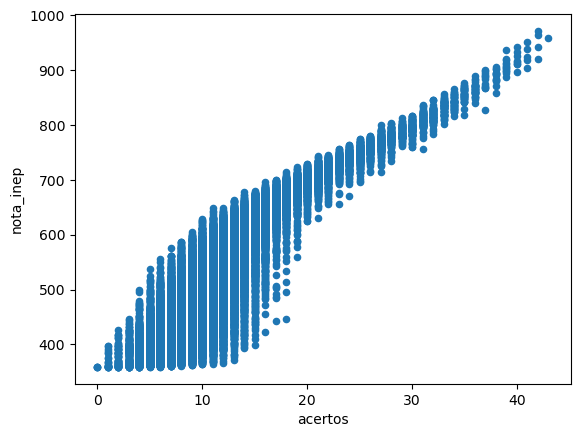

In [139]:
mt.plot(x='acertos',y='nota_inep',kind='scatter')